# Challenge 1: Binary Class Image Classification Using Machine Learning

Students: <br>
Abdelrahman Habib <br>
Luisana Álvarez Monsalve

Table of Contents
1. Imports
2. Helper Classes & Functions
3. Preprocessing
4. Feature Extraction
5. Machine Learning Pipeline
6. Test Prediction

The `Machine Learning Pipeline` section consists of different subsections that includes the experiments we performed, models used, evaluations and results, and final models used in predictions.

### 1. Imports

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
sys.path.append('../helpers/')

import os
from pathlib import Path
import pickle
import pprint
import seaborn as sns
import cv2
import joblib

from scipy.stats import mode, skew, kurtosis, entropy
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
import cmath

import pickle

from glob import glob
import natsort
import csv
import random
from tqdm import tqdm


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, cohen_kappa_score, multilabel_confusion_matrix, balanced_accuracy_score, confusion_matrix, roc_auc_score

pp = pprint.PrettyPrinter(indent=4)

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

### 2. Helper Classes & Functions

Preprocessing Class used to preprocess the images by cropping the black frames to reduce black background, resizing images and preserving the ratio, and removing the hair.

In [2]:
class Preprocessing:
    def __init__(self) -> None:
        pass

    def resize_images(self, image, new_size=(227, 227), preserve_ratio = False):
        '''Resizing function to handle image sizes from different datasets. It can resize to a fixed 
        ratio, or preserve the ratio as HAM10000 dataset aspect ratio.
        '''
        height, width       = image.shape[:2]

        # print(f"i/p image shape (h, w, c): {image.shape}")

        # Option to preserve the ratio of all images, so resizing all images' longer 
        # side to 600 pixels while preserving the aspect ratio.
        if(preserve_ratio):
            # if HAM10000, don't resize
            if (height, width) == (450, 600):
                return image        
            
            # HAM10000 aspect ratio is 600 / 450 = 1.33333333 
            image_aspect_ratio = float(600) / 450

            # print(f"Resizing as HAM10000 ratio with the longest side = 600 : {image_aspect_ratio}")

            if width > height:
                new_width = 600
                new_height = int(new_width / image_aspect_ratio)
            else:
                new_height = 600
                new_width = int(new_height * image_aspect_ratio)

            resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

        else:
            # For consistency, all the images are resized to 227×227×3.
            resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)

        return resized_image

    def extract_hair(self, img):

        # Convert RGB to grayscale
        img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        clip_limit = 1.0 # 10.0
        tile_size = 10 # 6
        CLAHE = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size,tile_size))
        img_CLAHE = CLAHE.apply(img_grayscale)

        # Apply Gaussian filter
        filter_size = 5
        filtered_image = cv2.GaussianBlur(img_CLAHE, (filter_size, filter_size), 0)

        # Canny edge detection
        # Calculate the median pixel value of the image
        median_value = np.median(filtered_image)
        # Define high and low thresholds for Canny
        high_threshold = median_value + 75
        low_threshold = median_value - 75
        # Apply Canny edge detection with the selected thresholds
        edges = cv2.Canny(filtered_image, low_threshold, high_threshold)

        # Dilation
        # Define the size of the dilation kernel (structuring element)
        kernel_size = (9, 9)  # Adjust the size as needed
        # Perform dilation
        dilated_image = cv2.dilate(edges, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size))

        inpainted_img = cv2.inpaint(img, dilated_image, inpaintRadius=5, flags=cv2.INPAINT_TELEA) # INPAINT_NS

        return inpainted_img  
      
    def crop_frame(self, image, threshold = 0.2, debug=False, margin=0.31):
        # Convert the image to grayscale
        gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
            
        # Gaussian blur and binarize
        blurred = cv2.GaussianBlur(gray, (0, 0), 2)
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find connected components and their properties
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Cropping flag for identifying cropped images
        CROP_FLAG = False

        if contours:        
            # Calculate the center and diameter of the largest component
            largest_contour = max(contours, key=cv2.contourArea)

            # finds a circle of the minimum area enclosing an area
            (x , y), radius = cv2.minEnclosingCircle(largest_contour) # returns the center and radius

            # casting from float to int for precision, necessary for visualizing 
            center = (int(x), int(y)) #(x, y)
            radius = int(radius)

            if debug:
                # for debugging we can visualize the contour of the minimum enclosing circle using its radius
                print(center, radius)
                cv2.circle(image, center, 5, (255, 0, 0), -1)   # viz the center as a dot (small radius)
                cv2.circle(image, center, radius, (255,0,0), 3) # viz the center as a crcle
            
            # Define the cropping box
            x_min = int(center[0] - radius)
            x_max = int(center[0] + radius)
            y_min = int(center[1] - radius)
            y_max = int(center[1] + radius)

            # check if we need to crop the images based on their intensities mean
            cropped_image = image.copy()[y_min:y_max, x_min:x_max]

            # Calculate mean values inside and outside the cropping box
            mean_inside = np.mean(cropped_image)

            # Calculate mean values outside the cropping box
            mean_above = np.mean(image[:y_min, :])
            mean_below = np.mean(image[y_max:, :])
            mean_left = np.mean(image[y_min:y_max, :x_min])
            mean_right = np.mean(image[y_min:y_max, x_max:])

            # Calculate mean_outside as the average of the four regions
            mean_outside = (mean_above + mean_below + mean_left + mean_right) / 4

            if mean_outside / mean_inside < threshold:
                # Define the cropping box with the required margin (TO EXCLUDE THE MARGIN FROM AFFECTING THIS VALIDATION)
                ret =  image.copy()[
                    int(center[1] - radius + margin * radius):int(center[1] + radius - margin * radius), 
                    int(center[0] - radius + margin * radius):int(center[0] + radius - margin * radius)]
                CROP_FLAG = True
            else: 
                # print("Doesn't required cropping")
                ret = image
        else:
            # print("No contours found, doesn't required cropping")
            ret = image

        return ret, CROP_FLAG

preprocessor = Preprocessing()

Feature Extraction Class to extract color features from multiple image regions, GLCM and LBP features

In [3]:
class FeatureExtraction:
    def __init__(self) -> None:
        pass

    def _plot_histogram(self, hist, title='Histogram'):
        # Determine the number of bins based on the length of the histogram
        num_bins = len(hist)

        # Create an array of bin edges
        bin_edges = np.arange(num_bins)

        # Create a bar plot for the histogram
        plt.bar(bin_edges, hist)

        # Set labels and a title
        plt.xlabel('Bin')
        plt.ylabel('Frequency')
        plt.title(title)

        # Show the plot
        plt.show()

    def calculate_hist_features(self, hist):
        feature_vector = []
        
        feature_vector.append(np.dot([i for i in range(0,256)], hist)) # Mean
        feature_vector.append(np.argmax(hist)) # Mode
        feature_vector.append(np.std(hist)) # Standard deviation
        feature_vector.append(skew(hist)) # Skewness
        feature_vector.append(np.sum(hist**2)) # Energy
        feature_vector.append(entropy(hist, base=2)) # Entropy
        feature_vector.append(kurtosis(hist)) # Kurtosis

        return np.array(feature_vector)
    
    def _compute_norm_hist(self, image, bins=256, range=(0, 256), gray=False, density=True):
        if not gray:
            hist_ch1, _ = np.histogram(image[:, :, 0], bins, range, density)
            hist_ch2, _ = np.histogram(image[:, :, 1], bins, range, density)
            hist_ch3, _ = np.histogram(image[:, :, 2], bins, range, density)

            # self._plot_histogram(hist_ch1)
            
            # hist_ch1 = hist_ch1 / np.sum(hist_ch1)
            # hist_ch2 = hist_ch2 / np.sum(hist_ch2)
            # hist_ch3 = hist_ch3 / np.sum(hist_ch3)

            # self._plot_histogram(hist_ch1)

            return hist_ch1, hist_ch2, hist_ch3
        else:
            hist_gray, _ = np.histogram(image, bins, range, density)
            # hist_gray = hist_gray / np.sum(hist_gray)

            return hist_gray
    
    def extract_color_features(self, img):
        # BGR
        hist_b, hist_g, hist_r = self._compute_norm_hist(img)

        # HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist_h, hist_s, hist_v = self._compute_norm_hist(hsv_img)

        # LAB
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        hist_L, hist_A, hist_B = self._compute_norm_hist(lab_img)

        # Gray
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist_gray = self._compute_norm_hist(gray_img, gray=True)

        color_features = np.concatenate((
            self.calculate_hist_features(hist_r), 
            self.calculate_hist_features(hist_g), 
            self.calculate_hist_features(hist_b),
            
            self.calculate_hist_features(hist_h), 
            self.calculate_hist_features(hist_s), 
            self.calculate_hist_features(hist_v),

            self.calculate_hist_features(hist_L),
            self.calculate_hist_features(hist_A),
            self.calculate_hist_features(hist_B),

            self.calculate_hist_features(hist_gray),
            )
        )

        return color_features
    
    def extract_glcm_features(self, image):    
        if not isinstance(image, np.ndarray):
            raise ValueError("Input must be a numpy array")

        if image.dtype != np.uint8:
            # If the image is not 8-bit, convert it to 8-bit
            # important as we set the levels for glcm to 256 for 8-bit images
            image = image.astype(np.uint8)

        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Compute GLCM matrix
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        glcm = graycomatrix(gray_image, distances, angles, levels=256, symmetric=True, normed=True)
        
        # Extract texture features from GLCM matrix
        features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        texture_features = np.concatenate([graycoprops(glcm, feature).ravel() for feature in features])
        
        return texture_features
    
    def extract_lbp_features(self, image):
        ''' 
        Extracts the histogram of the LBP image for a certain number of neighbours and radius.

        Args:
            image (numpy.ndarray): the image from which the LBP features will be extracted (cropped ROI)
            P (int): number of neighbours
            R (int): radius
        Output:
            hist (numpy.array): histogram of the LBP image
        '''

        P=[8, 16] 
        R=[1, 2]
        histogram = []

        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        for idx, P_value in enumerate(P):

            n_points = P_value * R[idx]

            lbp_image = local_binary_pattern(gray_image, n_points, R[idx], method='uniform')

            # Calculate the histogram of the LBP image
            hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2), density=True)

            # Normalize the histogram
            hist /= np.sum(hist)

            histogram = np.concatenate((histogram, hist))
        
        return histogram

    def extract_hog_features(self, image):
        """
        Extract HOG features from an input image.

        Parameters:
        - image: Input image (grayscale).

        Returns:
        - hog_features: The extracted HOG features.
        """
        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        # Define HOG parameters (you can customize these as needed)
        pixels_per_cell = (8, 8)
        cells_per_block = (2, 2)
        orientations = 9

        # Compute HOG features
        hog_features = hog(gray_image, pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           orientations=orientations)
        
        return hog_features
    
    def region_based_hist_fe(self, callback_func, image):
        # We split the image into 3 parts, each is 1/3 of the original height
        height, _, _ = image.shape
        partial_height = height // 3

        # Sotring the images into a list to iterate through them and get the feature vector for each part separately
        images_list = [
            image[0:partial_height, :],
            image[partial_height:2*partial_height, :],
            image[2*partial_height:, :],
        ]

        feature_vector = []

        for img in images_list:
            partial_feature_vector = callback_func(img)
            feature_vector = np.concatenate((feature_vector, partial_feature_vector))

        return feature_vector

    def fit(self, image):
        # color_features      = self.extract_color_features(image)
        color_features      = self.region_based_hist_fe(
            callback_func=self.extract_color_features,
            image=image
        )
        texture_features    = self.extract_glcm_features(image)
        lbp_features        = self.extract_lbp_features(image)
        # hog_features        = self.extract_hog_features(image) # 1 file of 7k samples ended up 24GB size

        all_features = np.concatenate((color_features, texture_features, lbp_features))

        return all_features


feature_extractor = FeatureExtraction()

Feature selection class that includes different methods for selecting features like SelectKBest and RFE

In [4]:
class FeatureSelection:
    def __init__(self) -> None:
        print(f"Init class FS {self.__dict__}")

    def calc_n_features(self, n_samples):
        '''
            Thumb rule = N >= D(D-1)/2
        '''
        a = 1
        b = -1
        c = -2 * n_samples

        # calculate the discriminant
        d = (b**2) - (4*a*c)

        # find two solutions
        sol1 = (-b-cmath.sqrt(d))/(2*a)
        sol2 = (-b+cmath.sqrt(d))/(2*a)

        n_features = int(np.max([np.round(np.abs(sol1)), np.round(np.abs(sol2))]))

        return n_features


    def select_bestk_features(self, data, target):

        # Get the best value of k from grid search
        best_k = self.calc_n_features(data.shape[0])

        # Apply Maximum Entropy-based feature selection with the best k
        selector = SelectKBest(k=best_k) # score_func=mutual_info_classif
        X_new = selector.fit_transform(data, target)

        # Get the indices of the selected features
        selected_features = np.where(selector.get_support())[0]

        # Convert X_new to a DataFrame with selected features
        selected_data = pd.DataFrame(X_new, columns=selected_features)

        return selected_data, selected_features
    
    def select_rfe_features(self, data, target):
        # estimator_svm = SVC(kernel='linear', decision_function_shape='ovr',class_weight='balanced')
        estimater_rfe = RandomForestClassifier(n_estimators=200, max_depth= 9, min_samples_leaf=1, min_samples_split=2 ,class_weight='balanced')

        rfe = RFE(estimater_rfe, n_features_to_select=self.calc_n_features(data.shape[0]), verbose=2)
        rfe.fit(data, target)
        
        # Get the indices of the selected features
        selected_features = np.where(rfe.support_)[0]

        # Convert the data to a DataFrame with the selected features
        selected_data = pd.DataFrame(data, columns=selected_features)
        
        # selected_features = rfe.support_
        # selected_data = data[:, selected_features]

        return selected_data, selected_features



select_feature = FeatureSelection()

Init class FS {}


In [5]:
def pprint_objects(*arg):
    '''Prints large and indented objects clearly.'''
    pp.pprint(arg)

def display_img(image, gray=False):
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        # plt.imshow(image)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')


def compare_models(models, param_grids, X_train, y_train, X_val, y_val, scoring_metric='accuracy', cv=10):
    '''Function used to train a single or multiple models and reports the results.
    '''
    all_models = []
    
    for model, param_grid in zip(models, param_grids):
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, verbose=0, scoring=scoring_metric)
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        # Store the best model and its parameters
        all_models.append({'model': best_model, 'params': best_params})
    
    # Evaluate the best models on a separate validation set
    models_report = []
    for model_info in all_models:
        model = model_info['model']
        y_pred = model.predict(X_val)

        # Accuracy score
        accuracy = accuracy_score(y_val, y_pred)
        kappa = cohen_kappa_score(y_val, y_pred)
        
        # F1 score
        f1 = f1_score(y_val, y_pred)

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_val, y_pred)
        true_positives = conf_matrix[1, 1]
        true_negatives = conf_matrix[0, 0]
        false_positives = conf_matrix[0, 1]
        false_negatives = conf_matrix[1, 0]

        # Sensitivity (True Positive Rate or Recall)
        sensitivity = true_positives / (true_positives + false_negatives)

        # Specificity (True Negative Rate)
        specificity = true_negatives / (true_negatives + false_positives)

        # Precision
        precision = true_positives / (true_positives + false_positives)

        models_report.append({
            'model': model, 
            'best_params': model_info['params'], 
            'accuracy': accuracy, 
            'kappa': kappa,
            'f1': f1, 
            'sensitivity': sensitivity, 
            'specificity': specificity,
            'precision': precision})
        
        models_report.sort(key=lambda x: x['accuracy'], reverse=True)

        plt.figure(figsize=(16, 6))
        plt.subplot(1,2,1)
        
        fpr, tpr, _ = roc_curve(y_val, y_pred)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)


        # plotting cm, nevus = 0, others = 1
        cm = confusion_matrix(y_val, y_pred)
        cm_df = pd.DataFrame(cm,
                            index=['nevus', 'others'],
                            columns=['nevus', 'others'])
        
        pprint_objects(cm)
        
        plt.subplot(1,2,2)
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Labels')
        plt.xlabel('Predicted Labels')
        plt.show()
    
    # return best_model, best_score, best_params, all_models
    return models_report


def predict_models(y_pred, y_val):
    '''Function used only for evaaluating the results.'''
    models_report  = []

    # Accuracy score
    accuracy = accuracy_score(y_val, y_pred)
    kappa = cohen_kappa_score(y_val, y_pred)
    
    # F1 score
    f1 = f1_score(y_val, y_pred)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    true_positives = conf_matrix[1, 1]
    true_negatives = conf_matrix[0, 0]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]

    # Sensitivity (True Positive Rate or Recall)
    sensitivity = true_positives / (true_positives + false_negatives)

    # Specificity (True Negative Rate)
    specificity = true_negatives / (true_negatives + false_positives)

    # Precision
    precision = true_positives / (true_positives + false_positives)

    models_report.append({
        'accuracy': accuracy, 
        'kappa': kappa,
        'f1': f1, 
        'sensitivity': sensitivity, 
        'specificity': specificity,
        'precision': precision})
    
    models_report.sort(key=lambda x: x['accuracy'], reverse=True)

    plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)


    # plotting cm, nevus = 0, others = 1
    cm = confusion_matrix(y_val, y_pred)
    cm_df = pd.DataFrame(cm,
                        index=['nevus', 'others'],
                        columns=['nevus', 'others'])
    
    pprint_objects(cm)
    
    plt.subplot(1,2,2)
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # return best_model, best_score, best_params, all_models
    return models_report


### 3. Preprocessing

Preprocessing images and saving them processed in pickles.

In [11]:
prep_imgs_dir = r'../output/'

# Pickle files names
nevus_train_prep_filename    = 'nevus_train_prep_images.pkl'
nevus_val_prep_filename      = 'nevus_val_prep_images.pkl'

others_train_prep_filename   = 'others_train_prep_images.pkl'
others_val_prep_filename     = 'others_val_prep_images.pkl'

# Directories to the datasets
ROOT_PATH = Path(Path(os.getcwd())/"../challenge1")
TRAIN_PATH = ROOT_PATH/"train"
VAL_PATH = ROOT_PATH/"val"

# Getting the images inside the directories and sorting them
train_nevus = sorted(glob(str(TRAIN_PATH/'nevus/*')))
train_others = sorted(glob(str(TRAIN_PATH/'others/*')))

val_nevus = sorted(glob(str(VAL_PATH/'nevus/*')))
val_others = sorted(glob(str(VAL_PATH/'others/*')))

# Storing all paths into a list
filenames_prep_list = [nevus_train_prep_filename, nevus_val_prep_filename, others_train_prep_filename,  others_val_prep_filename]
dir_list = [train_nevus, val_nevus, train_others, val_others]

In [ ]:
# subsampling flag to process only small subsample of the dataset
subsample               = False

for index, filename in enumerate(filenames_prep_list):

    preprocessed_images = []

    for count, image_path in tqdm(enumerate(dir_list[index])):

        if subsample:
            if count == 999: # only 1k per class
                break

        # reading the image 
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)

        # 1. Copping black frame
        image_without_black_frame, _ = preprocessor.crop_frame(image)

        # 2. Resizing
        image_resized = preprocessor.resize_images(image_without_black_frame, preserve_ratio=True)

        # 3. Removing hair
        image_without_hair = preprocessor.extract_hair(image_resized)

        # Saving the preprocessed image to a list
        preprocessed_images.append(image_without_hair)

    # Saving the preprocessed images to a file
    with open(prep_imgs_dir+filename, 'wb') as file:
        pickle.dump(preprocessed_images, file)

### 4. Feature Extraction

Now as we have the pickles saved, we can read the processed images from them and extract features

In [ ]:
features_dir = r'../output/features/'

experiment              = 4
subsample               = False

nevus_train_filename    = f'{experiment}_nevus_train_features.csv'
nevus_val_filename      = f'{experiment}_nevus_val_features.csv'

others_train_filename   = f'{experiment}_others_train_features.csv'
others_val_filename     = f'{experiment}_others_val_features.csv'

filenames_list = [nevus_train_filename, nevus_val_filename, others_train_filename, others_val_filename]

labels = [0, 0, 1, 1]

for pickle_filename, filename, label in zip(filenames_prep_list, filenames_list, labels):
    pickle_path = os.path.join(prep_imgs_dir, pickle_filename)

    with open(pickle_path, 'rb') as file:
        # Use a generator to load and yield images one at a time
        def image_generator():
            count = 0
            try:
                while True:
                    image_list = pickle.load(file)
                    for image in image_list:
                        yield image
                        count += 1
                        if subsample and count == 1:  # Only 1k per class
                            return
            except EOFError:
                pass

        with open(os.path.join(features_dir, filename), 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)

            count = 0
            for preprocessed_image in tqdm(image_generator(), desc=f"Processing {filename}"):
                if subsample and count == 9:  # Only 1k per class
                    break

                # 5. Extracting features
                feature_vector = feature_extractor.fit(preprocessed_image)

                # 6. Add label column
                feature_vector = np.append(feature_vector, label)

                # Write the feature vector to the CSV file
                writer.writerow(feature_vector)

                count += 1

Now we should have a csv file that contains all of the features for all of the samples obtained.

### 5. Machine Learning Pipeline

##### 5.1 Experimenting different models and approaches using only training and validation datasets using (Feature Selection: SelectBestK)

In [12]:
# Loading the features with the correct experiment number
experiment              = 4

ROOT_PATH = Path(Path(os.getcwd())/"../output/features")

train_nevus_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_train_features.csv',  header = None, on_bad_lines='skip')
val_nevus_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_val_features.csv',  header = None, on_bad_lines='skip')

train_others_df = pd.read_csv(ROOT_PATH/f'{experiment}_others_train_features.csv',  header = None, on_bad_lines='skip')
val_others_df = pd.read_csv(ROOT_PATH/f'{experiment}_others_val_features.csv',  header = None, on_bad_lines='skip')

In [20]:
train_nevus_df.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,157.238011,171.0,0.011527,3.817046,0.037923,5.342307,14.526250,125.662256,138.0,0.010243,...,0.017826,0.016285,0.018685,0.018685,0.020074,0.014141,0.007319,0.073348,0.347937,0.0
1,201.937144,210.0,0.011170,3.019431,0.035846,5.016944,8.244900,202.228206,205.0,0.012582,...,0.023696,0.018056,0.024837,0.016727,0.018650,0.008077,0.005560,0.079812,0.259552,0.0
2,149.933744,160.0,0.013459,4.990924,0.050281,5.082027,26.411318,140.707456,149.0,0.011807,...,0.015440,0.013021,0.018877,0.019531,0.023338,0.015481,0.008381,0.089910,0.400306,0.0
3,180.062478,188.0,0.011649,4.138790,0.038645,5.263665,17.426843,159.837622,178.0,0.009461,...,0.018000,0.016330,0.018767,0.017930,0.019574,0.013581,0.008611,0.073663,0.340263,0.0
4,201.379756,205.0,0.012416,4.031809,0.043372,5.068116,15.864496,142.026344,150.0,0.008790,...,0.013619,0.015311,0.017493,0.019781,0.023619,0.019993,0.012359,0.087644,0.432200,0.0


In [8]:
train_others_df.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,143.418712,174.0,0.005047,1.647879,0.010427,6.862629,2.397556,133.337806,157.0,0.004276,...,0.007885,0.008702,0.010465,0.013727,0.020567,0.022927,0.016177,0.081679,0.478398,1.0
1,177.313831,178.0,0.012857,4.181146,0.046224,4.948662,17.335125,143.204200,148.0,0.008623,...,0.014958,0.015119,0.016079,0.017165,0.019433,0.016565,0.011448,0.065283,0.367760,1.0
2,142.869469,144.0,0.016490,4.991996,0.073516,4.156845,24.959298,120.942394,122.0,0.011405,...,0.005950,0.006917,0.008635,0.012485,0.021433,0.026533,0.019844,0.092346,0.538815,1.0
3,203.101750,212.0,0.010098,2.993415,0.030013,5.361549,8.389612,162.374181,183.0,0.005913,...,0.020852,0.012883,0.016331,0.008248,0.009779,0.003494,0.002002,0.046194,0.136567,1.0
4,130.405944,1.0,0.008476,3.704305,0.022298,6.297036,14.614478,86.601575,1.0,0.007339,...,0.014727,0.012560,0.016387,0.014988,0.017108,0.012425,0.007321,0.091177,0.312458,1.0


In [21]:
print(f"Shape of training dataframe for nevus class: {train_nevus_df.shape}")
print(f"Shape of training dataframe for others class: {train_others_df.shape}")

Shape of training dataframe for nevus class: (7725, 279)
Shape of training dataframe for others class: (7470, 279)


In [10]:
val_nevus_df.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,179.957963,196.0,0.010615,3.289989,0.032755,5.550535,9.696586,177.849469,190.0,0.012221,...,0.015652,0.014783,0.015896,0.017254,0.020160,0.016035,0.009071,0.069790,0.385342,0.0
1,214.950933,231.0,0.008005,2.540727,0.020311,5.943256,6.297179,112.850000,148.0,0.005946,...,0.014693,0.015052,0.017415,0.018481,0.021189,0.018237,0.010619,0.075759,0.398167,0.0
2,198.330887,204.0,0.009431,2.845644,0.026678,5.660727,7.344996,195.295969,205.0,0.007567,...,0.015067,0.013090,0.016567,0.016644,0.019877,0.014017,0.009719,0.074842,0.349240,0.0
3,181.317969,222.0,0.010014,4.924824,0.029576,6.188504,25.821507,177.972475,226.0,0.008768,...,0.014617,0.011673,0.019523,0.016050,0.019467,0.012125,0.007575,0.090821,0.337288,0.0
4,218.419756,233.0,0.008792,2.812908,0.023697,5.951481,6.667646,127.764156,147.0,0.008216,...,0.015430,0.016370,0.018485,0.020096,0.022307,0.018070,0.010526,0.079141,0.393970,0.0


In [12]:
val_others_df.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,116.435262,1.0,0.007016,2.545273,0.016508,6.463351,6.527959,104.308475,1.0,0.005535,...,0.009160,0.008281,0.009402,0.011321,0.014533,0.012165,0.006221,0.077381,0.331912,1.0
1,172.058600,178.0,0.008495,2.284776,0.022379,5.727040,3.955654,130.444322,129.0,0.006868,...,0.018393,0.016711,0.016604,0.015752,0.015133,0.010811,0.006707,0.049419,0.249822,1.0
2,214.548919,220.0,0.010418,3.310539,0.031692,5.513930,10.273278,163.268256,173.0,0.005883,...,0.022350,0.017319,0.020460,0.013996,0.014640,0.006188,0.004035,0.055819,0.200540,1.0
3,195.090413,210.0,0.008363,2.197036,0.021812,5.727158,3.700458,156.711038,179.0,0.006994,...,0.019563,0.018921,0.019071,0.017825,0.017877,0.011727,0.007088,0.063573,0.286894,1.0
4,159.246500,192.0,0.007095,2.714642,0.016793,6.542190,6.763010,148.376925,185.0,0.005194,...,0.014331,0.012035,0.014646,0.015773,0.018304,0.012823,0.006744,0.071442,0.349892,1.0


In [22]:
print(f"Shape of validation dataframe for nevus class: {val_nevus_df.shape}")
print(f"Shape of validation dataframe for others class: {val_others_df.shape}")


Shape of validation dataframe for nevus class: (1931, 279)
Shape of validation dataframe for others class: (1865, 279)


In [24]:
# Concatenate the 'nevus' and 'others' dataframes
train_features = pd.concat([train_nevus_df, train_others_df], ignore_index=True)
val_features = pd.concat([val_nevus_df, val_others_df], ignore_index=True)

# Shuffle the dataset
train_features = train_features.sample(frac=1, random_state=42)
val_features = val_features.sample(frac=1, random_state=42)


In [25]:
# Separating the train and validation data to X and y
X_train = train_features.iloc[:,:-1]
y_train = train_features.iloc[:,-1]

X_val = val_features.iloc[:,:-1]
y_val = val_features.iloc[:,-1]

X_val.head()


,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,277
298,212.652089,219.0,0.009457,2.665059,0.026803,5.532736,5.940784,119.166433,130.0,0.007473,...,0.014026,0.016085,0.016507,0.017385,0.018948,0.020730,0.016674,0.009863,0.074107,0.383415
3078,140.089919,144.0,0.014141,4.364045,0.055098,4.548942,19.329565,137.560350,143.0,0.013271,...,0.012302,0.016102,0.014113,0.019015,0.019960,0.023742,0.015706,0.008215,0.085862,0.402779
1361,231.208733,233.0,0.012122,3.633604,0.041522,4.928246,12.652456,146.975678,152.0,0.012379,...,0.012119,0.014759,0.016548,0.018219,0.020744,0.022841,0.018789,0.011419,0.084244,0.417467
2711,186.715878,197.0,0.008878,2.435293,0.024086,5.627522,4.876680,163.850789,175.0,0.007880,...,0.016296,0.019978,0.018000,0.019419,0.019122,0.018741,0.011352,0.006978,0.068337,0.319848
2416,205.468500,210.0,0.008173,2.031932,0.021007,5.772153,2.954551,174.191111,181.0,0.007760,...,0.014196,0.016559,0.016563,0.017363,0.018485,0.019930,0.015433,0.008863,0.071107,0.369211


In [26]:
# Standardizing the training data (mean = 0, std = 1)
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_val_normalized = pd.DataFrame(scaler.transform(X_val))

In [27]:
# Encoding the label column
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

In [28]:
print(X_train_normalized.shape, y_train_encoded.shape, X_val_normalized.shape, y_val_encoded.shape)

(15195, 278) (15195,) (3796, 278) (3796,)


In [31]:
X_train_normalized, selected_feature_indices  = select_feature.select_bestk_features(X_train_normalized, y_train_encoded)
X_train_normalized

,0,1,2,4,5,9,10,11,12,16,...,264,265,266,267,272,273,274,275,276,277
0,0.710341,0.524124,0.486763,0.294037,-0.176257,-0.106707,0.629025,-0.231031,0.522873,-0.301301,...,2.017127,2.075348,2.238380,1.905105,-1.716545,-1.740642,-2.136828,-1.805050,-0.916389,-2.161680
1,-0.689763,-0.208064,-0.622911,-0.604195,0.197348,-0.614919,-1.030404,-0.616179,0.203885,-0.991778,...,-1.846171,-1.809442,-1.681014,-1.691096,1.373702,1.964484,1.543964,1.339291,1.700337,1.286000
2,0.377737,0.196566,0.532010,0.338160,-0.784911,0.109627,-0.307511,-0.044996,-0.438307,0.529021,...,0.412458,0.474552,0.415499,0.861970,0.310844,-0.541963,-0.424556,-0.415314,-0.551476,-0.342822
3,-0.476263,0.389248,-1.674190,-1.129205,1.845407,-1.856198,-2.095830,-1.250860,1.964529,-2.024165,...,1.606327,1.392723,0.892792,1.146730,-1.516381,-2.147844,-0.962596,-0.368456,-1.688512,-1.424114
4,0.408745,0.292907,0.057857,-0.095037,-0.161669,0.577241,0.401680,0.402197,-0.586513,0.675917,...,-0.547379,-0.479828,-0.387313,-0.325700,0.535590,0.501397,0.593768,0.987965,0.021846,0.310747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15190,1.024603,0.639733,1.354952,1.243176,-1.239340,0.563684,0.423614,0.388365,-0.568074,0.652987,...,-1.358902,0.186551,2.725339,-1.234335,-1.116053,2.870439,-2.261147,-1.694242,5.460186,-1.060395
15191,-1.199237,-0.651231,0.798001,0.609424,-0.726204,1.396223,1.039476,1.333898,-1.324528,1.579573,...,-0.215420,0.002698,0.337807,0.731264,1.353412,0.636220,-0.345326,-0.460507,0.279046,-0.003455
15192,-0.853495,-0.554890,1.250756,1.117844,-1.330004,1.548136,1.077535,1.527503,-1.497690,1.064994,...,-2.434095,-2.541806,-2.423522,-2.873234,-1.497945,1.395358,2.988414,3.397714,1.675418,2.715616
15193,-0.301218,-0.188796,1.079525,0.918644,-1.082544,0.959614,1.154596,0.813671,-0.763359,0.775324,...,0.872143,1.108772,1.423268,1.583423,-0.486689,-0.712010,-0.892435,-0.830157,-0.129119,-0.589661


In [32]:
selected_feature_indices

array([  0,   1,   2,   4,   5,   9,  10,  11,  12,  16,  17,  18,  19,
        23,  24,  25,  26,  27,  28,  29,  30,  32,  33,  35,  36,  37,
        39,  40,  42,  43,  44,  45,  46,  47,  49,  50,  51,  52,  53,
        54,  55,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        70,  71,  80,  83,  86,  87,  88,  90,  93,  94,  95,  96,  97,
        98, 100, 101, 102, 104, 105, 106, 115, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 129, 132, 136, 139, 140, 141, 142, 145, 149,
       150, 151, 152, 156, 157, 158, 159, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 175, 176, 177, 180, 182, 183, 184, 185,
       186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 223, 224, 225, 234, 235,
       237, 238, 239, 241, 243, 244, 245, 246, 247, 248, 252, 253, 254,
       255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
       272, 273, 274, 275, 276, 277], dtype=int64)

In [33]:
X_val_normalized = X_val_normalized.iloc[:, selected_feature_indices]
X_val_normalized

,0,1,2,4,5,9,10,11,12,16,...,264,265,266,267,272,273,274,275,276,277
0,0.932686,0.601197,-0.367194,-0.428535,0.093095,-0.365834,-0.364341,-0.436505,0.191786,-0.652664,...,-0.420286,-0.229036,-0.300742,0.125079,0.761896,0.333779,0.398610,0.173344,-0.041378,0.381740
1,-1.387935,-0.843912,0.881643,0.698920,-1.038604,1.716244,1.072686,1.749329,-1.742017,2.844501,...,-0.287265,-0.481495,-0.194333,-0.168558,1.188463,1.321570,0.180673,-0.342384,0.641163,0.649160
2,1.526149,0.870950,0.343229,0.157956,-0.602275,1.395741,1.132931,1.333293,-1.228546,0.857317,...,-1.130996,-0.890699,-0.959270,-0.661212,1.518850,1.026113,0.874828,0.660031,0.547213,0.851994
3,0.103216,0.177298,-0.521527,-0.536796,0.202131,-0.219792,-0.544467,-0.323030,-0.082182,-0.321277,...,0.540816,0.772605,0.940841,1.253057,0.835250,-0.318473,-0.799860,-0.729343,-0.376426,-0.496112
4,0.702947,0.427784,-0.709589,-0.659478,0.368505,-0.263105,-0.538476,-0.357311,-0.039471,-0.509428,...,-0.189495,-0.062096,-0.231190,0.296952,0.566804,0.071421,0.119217,-0.139525,-0.215569,0.185588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,-0.476363,-0.381477,-0.418905,-0.465571,0.222348,-0.205404,-0.217525,-0.311524,0.174506,0.177381,...,-0.434829,-0.402837,-0.423569,-0.122952,1.222311,0.805052,0.383598,0.052832,0.334529,0.285377
3792,-0.254519,-0.092455,0.827948,0.641236,-0.690768,0.666532,0.889952,0.494596,-0.445862,0.229248,...,-0.993628,-1.012331,-1.029654,-1.062398,0.256121,1.377594,1.251696,0.715507,0.782571,1.462105
3793,0.412156,0.350711,0.040152,-0.109963,-0.355506,0.063847,0.663880,-0.085464,-0.000051,-0.365403,...,-0.218265,-0.384161,-0.390781,-0.150612,-0.131915,0.330894,0.544717,0.165378,-0.071082,0.726352
3794,0.417418,0.408516,-0.597652,-0.587679,0.325465,-0.331378,-0.510749,-0.410275,0.144808,-0.266466,...,0.094409,0.210039,0.275654,0.631434,1.298787,0.044699,-0.152670,-0.124461,-0.632980,-0.371362


(array([[1605,  326],
       [ 339, 1526]], dtype=int64),)


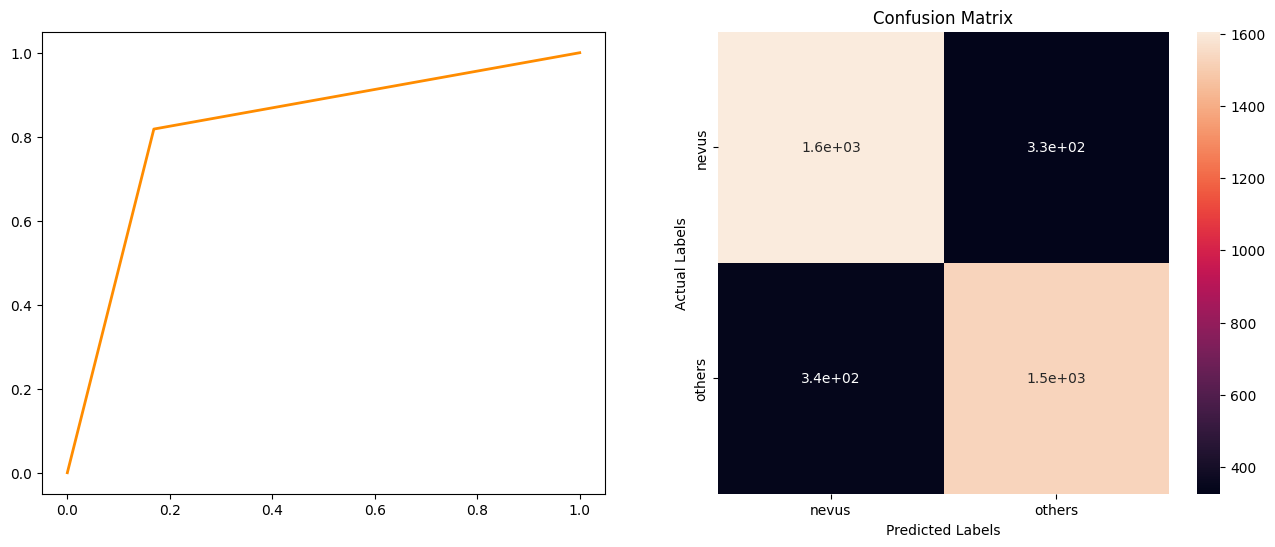

(   [   {   'accuracy': 0.8248155953635405,
            'best_params': {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
            'f1': 0.8210922787193974,
            'kappa': 0.6494834882303966,
            'model': SVC(C=10, gamma=0.01),
            'precision': 0.8239740820734341,
            'sensitivity': 0.8182305630026809,
            'specificity': 0.8311755567063698}],)


In [35]:
# Define the list of models and their respective hyperparameter grids
models = [
    SVC()
    ] 

param_grids = [
    {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.001, 0.01, 0.1]},
]

# Call the function to compare models and get the best one
models_report = compare_models(
    models, 
    param_grids, 
    X_train_normalized, 
    y_train_encoded, 
    X_val_normalized, 
    y_val_encoded, 
    scoring_metric='accuracy', 
    cv=5)

pprint_objects(models_report)

(array([[1559,  372],
       [ 416, 1449]], dtype=int64),)


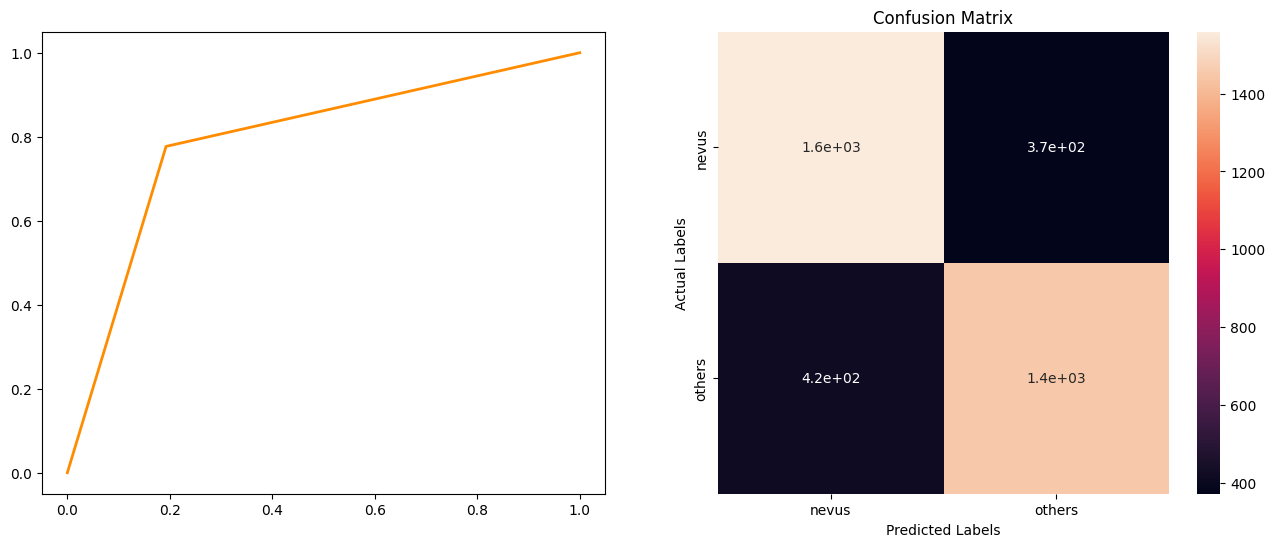

(   [   {   'accuracy': 0.7924130663856691,
            'best_params': {   'C': 0.1,
                               'penalty': None,
                               'solver': 'newton-cholesky'},
            'f1': 0.786218122626153,
            'kappa': 0.5845330780643596,
            'model': LogisticRegression(C=0.1, penalty=None, solver='newton-cholesky'),
            'precision': 0.7957166392092258,
            'sensitivity': 0.7769436997319035,
            'specificity': 0.8073537027446919}],)


In [36]:
# Define the list of models and their respective hyperparameter grids
models = [
    LogisticRegression()
    ] 

param_grids = [
    {'penalty' : ['l1', 'l2', 'elasticnet', None], 'C':[0.1, 1, 10], 'solver': ['lbfgs', 'newton-cholesky', 'sag', 'saga']},
]

# Call the function to compare models and get the best one
models_report = compare_models(
    models, 
    param_grids, 
    X_train_normalized, 
    y_train_encoded, 
    X_val_normalized, 
    y_val_encoded, 
    scoring_metric='accuracy', 
    cv=5)

pprint_objects(models_report)

(array([[1451,  480],
       [ 312, 1553]], dtype=int64),)


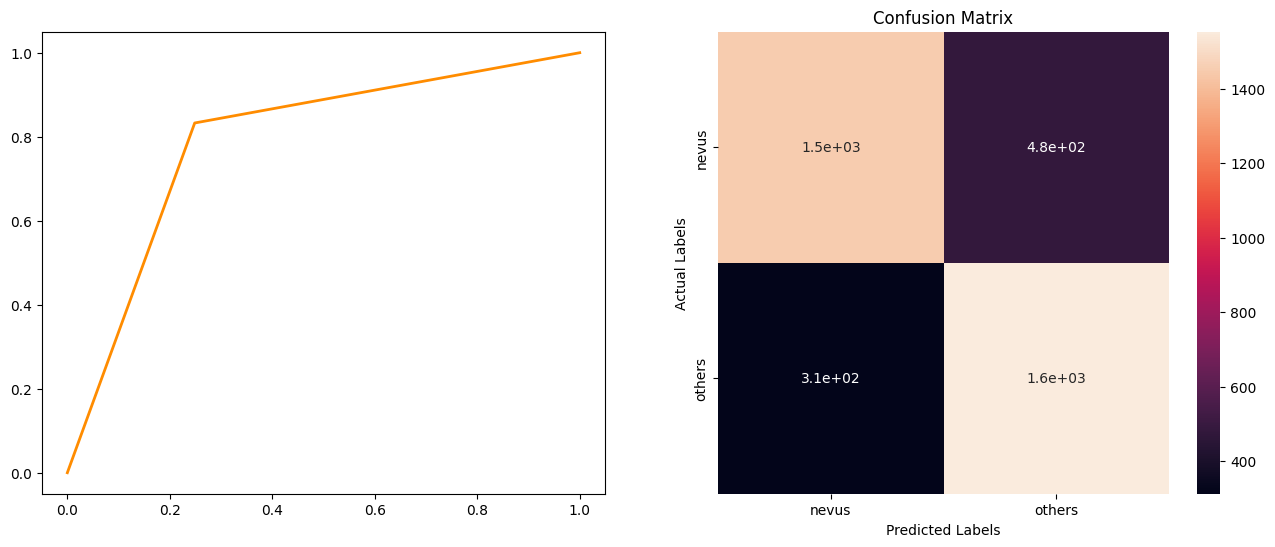

(   [   {   'accuracy': 0.7913593256059009,
            'best_params': {   'algorithm': 'ball_tree',
                               'n_neighbors': 5,
                               'p': 1,
                               'weights': 'distance'},
            'f1': 0.796818881477681,
            'kappa': 0.5832340548937455,
            'model': KNeighborsClassifier(algorithm='ball_tree', p=1, weights='distance'),
            'precision': 0.763895720609936,
            'sensitivity': 0.8327077747989277,
            'specificity': 0.7514241325737959}],)


In [37]:
# Define the list of models and their respective hyperparameter grids
models = [
    KNeighborsClassifier()
    ] 
        
param_grids = [
    {'n_neighbors': [3, 5, 7, 9], 'weights' : ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': [1, 2]}, 
]

# Call the function to compare models and get the best one
models_report = compare_models(
    models, 
    param_grids, 
    X_train_normalized, 
    y_train_encoded, 
    X_val_normalized, 
    y_val_encoded, 
    scoring_metric='accuracy', 
    cv=5)

pprint_objects(models_report)

(array([[1472,  459],
       [ 391, 1474]], dtype=int64),)


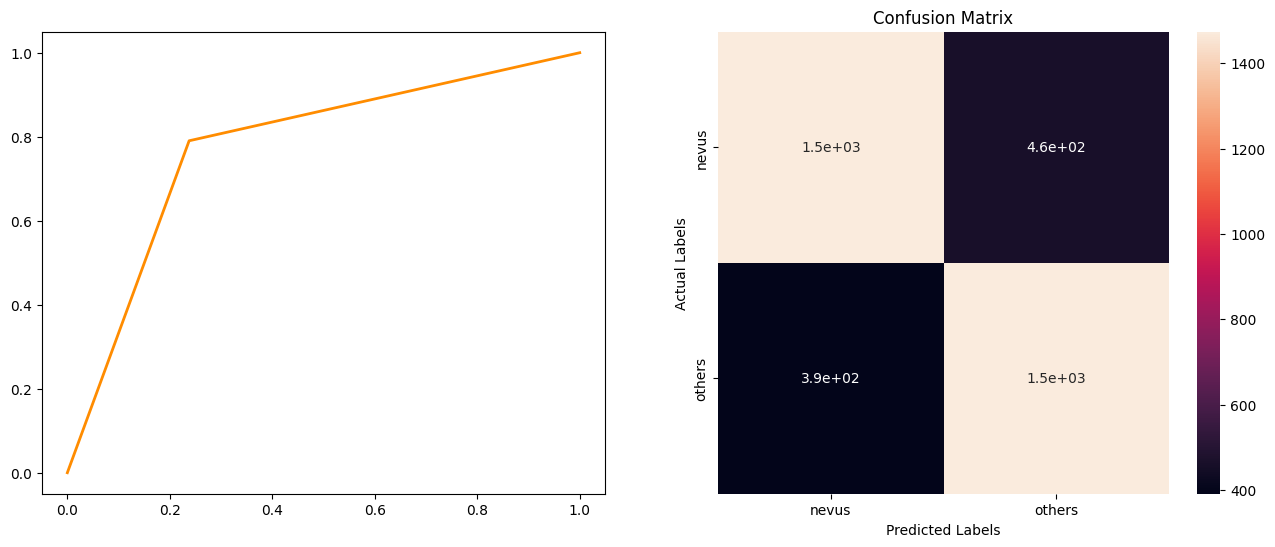

(   [   {   'accuracy': 0.7760800842992623,
            'best_params': {   'max_depth': 9,
                               'min_samples_leaf': 1,
                               'min_samples_split': 5,
                               'n_estimators': 100},
            'f1': 0.7761979989468143,
            'kappa': 0.5523037086391537,
            'model': RandomForestClassifier(max_depth=9, min_samples_split=5),
            'precision': 0.7625452664252458,
            'sensitivity': 0.7903485254691689,
            'specificity': 0.7622993267736924}],)


In [39]:
# Define the list of models and their respective hyperparameter grids
models = [
    RandomForestClassifier()
    ] 

param_grids = [
    {'n_estimators' : [50, 100, 200], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}, # still takes a lot of time
]

# Call the function to compare models and get the best one
models_report = compare_models(
    models, 
    param_grids, 
    X_train_normalized, 
    y_train_encoded, 
    X_val_normalized, 
    y_val_encoded, 
    scoring_metric='accuracy', 
    cv=5)

pprint_objects(models_report)

(array([[1557,  374],
       [ 405, 1460]], dtype=int64),)


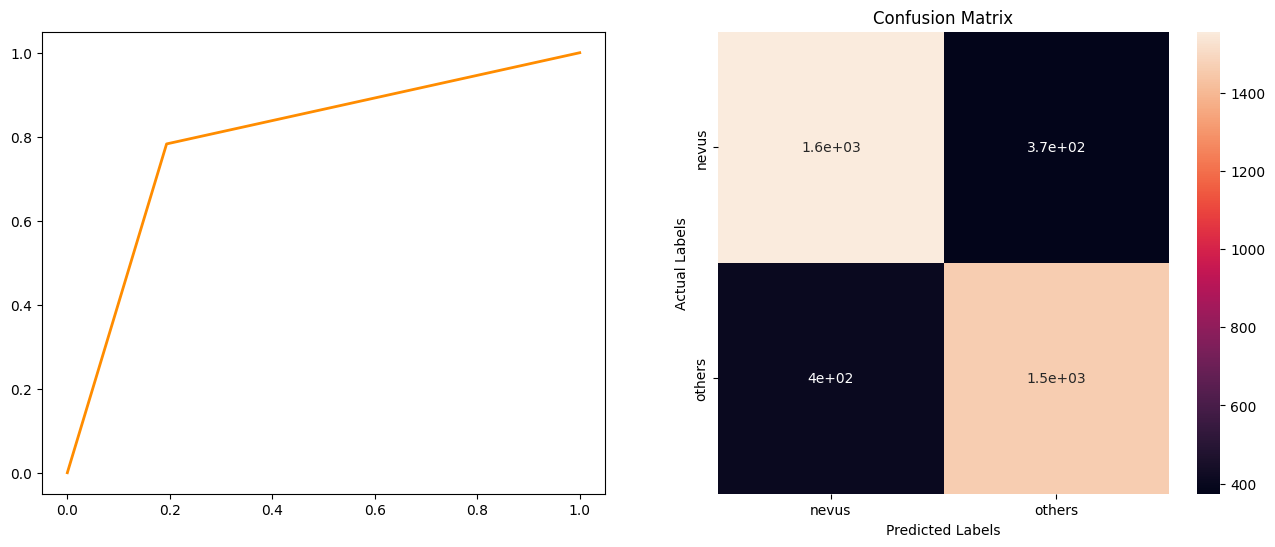

(   [   {   'accuracy': 0.7947839831401475,
            'best_params': {'shrinkage': None, 'solver': 'svd'},
            'f1': 0.7894025412273586,
            'kappa': 0.5893271990160798,
            'model': LinearDiscriminantAnalysis(),
            'precision': 0.7960741548527808,
            'sensitivity': 0.7828418230563002,
            'specificity': 0.8063179699637494}],)


In [40]:
# Define the list of models and their respective hyperparameter grids
models = [
    LinearDiscriminantAnalysis(),
    ] 
        
param_grids = [
    {'solver': ['svd', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 1.0]},
]

# Call the function to compare models and get the best one
models_report = compare_models(
    models, 
    param_grids, 
    X_train_normalized, 
    y_train_encoded, 
    X_val_normalized, 
    y_val_encoded, 
    scoring_metric='accuracy', 
    cv=5)

pprint_objects(models_report)

(array([[1578,  353],
       [ 380, 1485]], dtype=int64),)


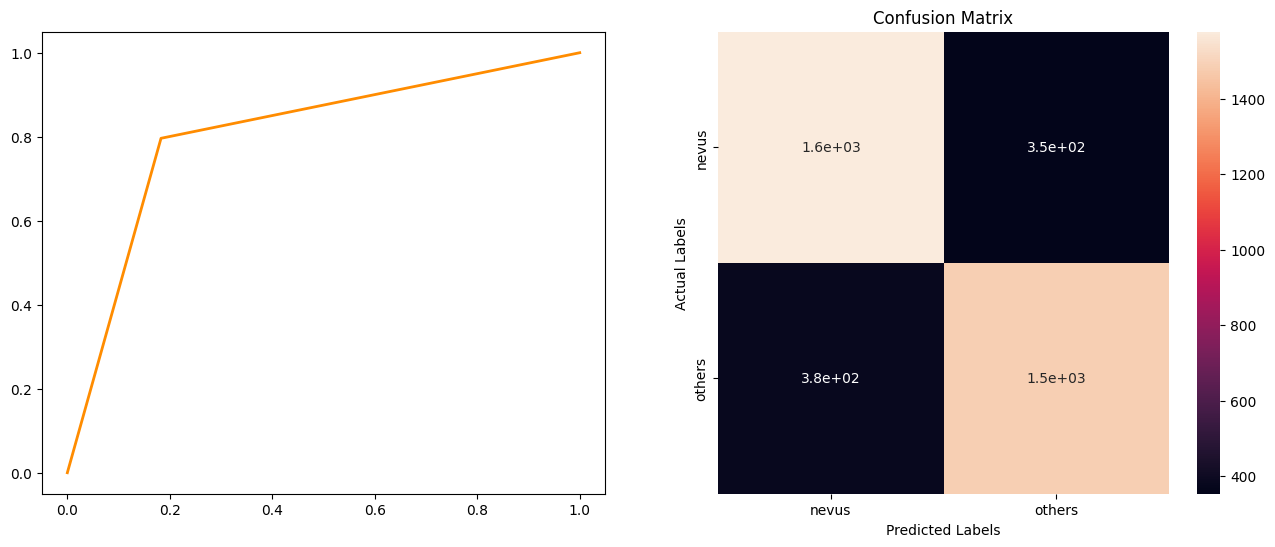

(   [   {   'accuracy': 0.8069020021074815,
            'best_params': {   'colsample_bytree': 0.8,
                               'learning_rate': 0.1,
                               'max_depth': 5,
                               'n_estimators': 300,
                               'subsample': 0.7},
            'f1': 0.8020523899540912,
            'kappa': 0.6135916214312536,
            'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, m

In [41]:
# Define the list of models and their respective hyperparameter grids
models = [
    XGBClassifier()
    ] 

param_grids = [
    {'max_depth': [4, 5], 'learning_rate': [0.1, 0.01], 'n_estimators': [200, 300], 'subsample': [0.5, 0.7, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0]}
]

# Call the function to compare models and get the best one
models_report = compare_models(
    models, 
    param_grids, 
    X_train_normalized, 
    y_train_encoded, 
    X_val_normalized, 
    y_val_encoded, 
    scoring_metric='accuracy', 
    cv=5)

pprint_objects(models_report)

##### 5.2 Training an ensemble (VotingClassifier) using the best models with their best parameters obtained from the previous runs, using only training and validation datasets with (Feature Selection: SelectBestK)

(array([[1621,  310],
       [ 329, 1536]], dtype=int64),)


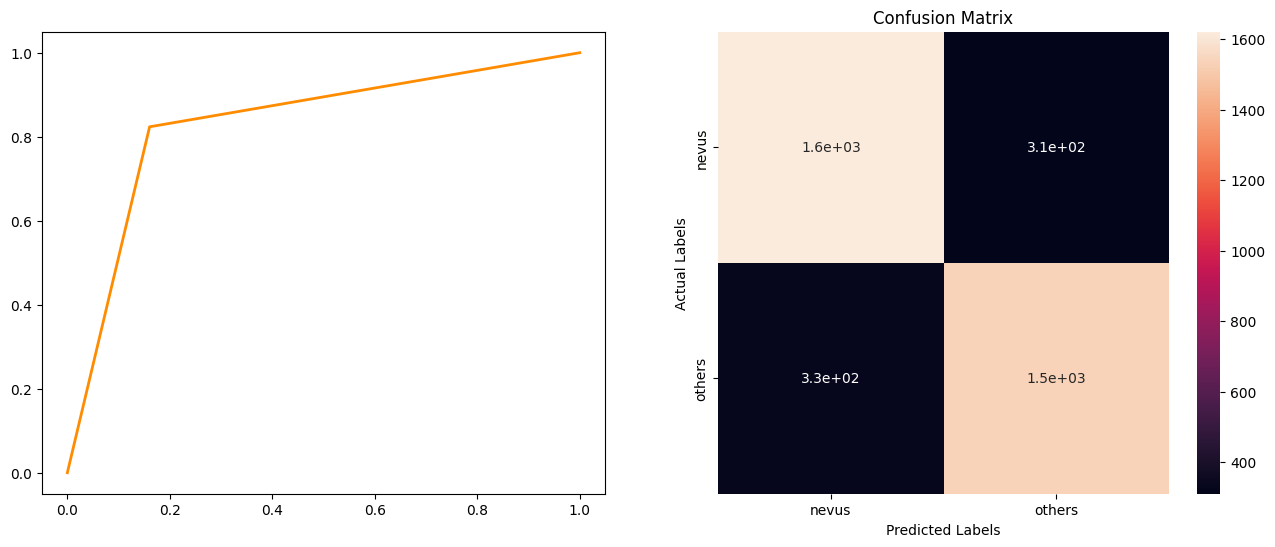

(   [   {   'accuracy': 0.8316649104320337,
            'f1': 0.8278092158447858,
            'kappa': 0.6631693720755589,
            'precision': 0.8320693391115926,
            'sensitivity': 0.8235924932975871,
            'specificity': 0.8394614189539099}],)


In [42]:
# Define the base classifiers
clf1 = SVC(C= 10, gamma=0.01, kernel='rbf', probability=True)  # Set probability=True for soft voting
clf2 = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7)

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(estimators=[('svc', clf1), ('xgb', clf2)], voting='soft')

# Train the VotingClassifier on your training data
voting_clf.fit(X_train_normalized, y_train_encoded)

# Make predictions
y_pred = voting_clf.predict(X_val_normalized)

models_report = predict_models(y_pred, y_val_encoded)

pprint_objects(models_report)

##### 5.3 Experimenting different models and approaches using only training and validation datasets using (Feature Selection: RFE)

In [6]:
# Loading the features with the correct experiment number
experiment              = 4

ROOT_PATH = Path(Path(os.getcwd())/"../output/features")

train_nevus_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_train_features.csv',  header = None, on_bad_lines='skip')
val_nevus_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_val_features.csv',  header = None, on_bad_lines='skip')

train_others_df = pd.read_csv(ROOT_PATH/f'{experiment}_others_train_features.csv',  header = None, on_bad_lines='skip')
val_others_df = pd.read_csv(ROOT_PATH/f'{experiment}_others_val_features.csv',  header = None, on_bad_lines='skip')

In [7]:
train_nevus_df.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,157.238011,171.0,0.011527,3.817046,0.037923,5.342307,14.526250,125.662256,138.0,0.010243,...,0.017826,0.016285,0.018685,0.018685,0.020074,0.014141,0.007319,0.073348,0.347937,0.0
1,201.937144,210.0,0.011170,3.019431,0.035846,5.016944,8.244900,202.228206,205.0,0.012582,...,0.023696,0.018056,0.024837,0.016727,0.018650,0.008077,0.005560,0.079812,0.259552,0.0
2,149.933744,160.0,0.013459,4.990924,0.050281,5.082027,26.411318,140.707456,149.0,0.011807,...,0.015440,0.013021,0.018877,0.019531,0.023338,0.015481,0.008381,0.089910,0.400306,0.0
3,180.062478,188.0,0.011649,4.138790,0.038645,5.263665,17.426843,159.837622,178.0,0.009461,...,0.018000,0.016330,0.018767,0.017930,0.019574,0.013581,0.008611,0.073663,0.340263,0.0
4,201.379756,205.0,0.012416,4.031809,0.043372,5.068116,15.864496,142.026344,150.0,0.008790,...,0.013619,0.015311,0.017493,0.019781,0.023619,0.019993,0.012359,0.087644,0.432200,0.0


In [8]:
train_others_df.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,143.418712,174.0,0.005047,1.647879,0.010427,6.862629,2.397556,133.337806,157.0,0.004276,...,0.007885,0.008702,0.010465,0.013727,0.020567,0.022927,0.016177,0.081679,0.478398,1.0
1,177.313831,178.0,0.012857,4.181146,0.046224,4.948662,17.335125,143.204200,148.0,0.008623,...,0.014958,0.015119,0.016079,0.017165,0.019433,0.016565,0.011448,0.065283,0.367760,1.0
2,142.869469,144.0,0.016490,4.991996,0.073516,4.156845,24.959298,120.942394,122.0,0.011405,...,0.005950,0.006917,0.008635,0.012485,0.021433,0.026533,0.019844,0.092346,0.538815,1.0
3,203.101750,212.0,0.010098,2.993415,0.030013,5.361549,8.389612,162.374181,183.0,0.005913,...,0.020852,0.012883,0.016331,0.008248,0.009779,0.003494,0.002002,0.046194,0.136567,1.0
4,130.405944,1.0,0.008476,3.704305,0.022298,6.297036,14.614478,86.601575,1.0,0.007339,...,0.014727,0.012560,0.016387,0.014988,0.017108,0.012425,0.007321,0.091177,0.312458,1.0


In [9]:
print(f"Shape of training dataframe for nevus class: {train_nevus_df.shape}")
print(f"Shape of training dataframe for others class: {train_others_df.shape}")

Shape of training dataframe for nevus class: (7725, 279)
Shape of training dataframe for others class: (7470, 279)


In [10]:
val_nevus_df.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,179.957963,196.0,0.010615,3.289989,0.032755,5.550535,9.696586,177.849469,190.0,0.012221,...,0.015652,0.014783,0.015896,0.017254,0.020160,0.016035,0.009071,0.069790,0.385342,0.0
1,214.950933,231.0,0.008005,2.540727,0.020311,5.943256,6.297179,112.850000,148.0,0.005946,...,0.014693,0.015052,0.017415,0.018481,0.021189,0.018237,0.010619,0.075759,0.398167,0.0
2,198.330887,204.0,0.009431,2.845644,0.026678,5.660727,7.344996,195.295969,205.0,0.007567,...,0.015067,0.013090,0.016567,0.016644,0.019877,0.014017,0.009719,0.074842,0.349240,0.0
3,181.317969,222.0,0.010014,4.924824,0.029576,6.188504,25.821507,177.972475,226.0,0.008768,...,0.014617,0.011673,0.019523,0.016050,0.019467,0.012125,0.007575,0.090821,0.337288,0.0
4,218.419756,233.0,0.008792,2.812908,0.023697,5.951481,6.667646,127.764156,147.0,0.008216,...,0.015430,0.016370,0.018485,0.020096,0.022307,0.018070,0.010526,0.079141,0.393970,0.0


In [11]:
val_others_df.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,116.435262,1.0,0.007016,2.545273,0.016508,6.463351,6.527959,104.308475,1.0,0.005535,...,0.009160,0.008281,0.009402,0.011321,0.014533,0.012165,0.006221,0.077381,0.331912,1.0
1,172.058600,178.0,0.008495,2.284776,0.022379,5.727040,3.955654,130.444322,129.0,0.006868,...,0.018393,0.016711,0.016604,0.015752,0.015133,0.010811,0.006707,0.049419,0.249822,1.0
2,214.548919,220.0,0.010418,3.310539,0.031692,5.513930,10.273278,163.268256,173.0,0.005883,...,0.022350,0.017319,0.020460,0.013996,0.014640,0.006188,0.004035,0.055819,0.200540,1.0
3,195.090413,210.0,0.008363,2.197036,0.021812,5.727158,3.700458,156.711038,179.0,0.006994,...,0.019563,0.018921,0.019071,0.017825,0.017877,0.011727,0.007088,0.063573,0.286894,1.0
4,159.246500,192.0,0.007095,2.714642,0.016793,6.542190,6.763010,148.376925,185.0,0.005194,...,0.014331,0.012035,0.014646,0.015773,0.018304,0.012823,0.006744,0.071442,0.349892,1.0


In [12]:
print(f"Shape of validation dataframe for nevus class: {val_nevus_df.shape}")
print(f"Shape of validation dataframe for others class: {val_others_df.shape}")

Shape of validation dataframe for nevus class: (1931, 279)
Shape of validation dataframe for others class: (1865, 279)


In [13]:
# Concatenate the 'nevus' and 'others' dataframes
train_features = pd.concat([train_nevus_df, train_others_df], ignore_index=True)
val_features = pd.concat([val_nevus_df, val_others_df], ignore_index=True)

# Shuffle the dataset
train_features = train_features.sample(frac=1, random_state=42)
val_features = val_features.sample(frac=1, random_state=42)

In [14]:
# Separating the train and validation data to X and y
X_train = train_features.iloc[:,:-1]
y_train = train_features.iloc[:,-1]

X_val = val_features.iloc[:,:-1]
y_val = val_features.iloc[:,-1]

X_val.head()

,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,277
298,212.652089,219.0,0.009457,2.665059,0.026803,5.532736,5.940784,119.166433,130.0,0.007473,...,0.014026,0.016085,0.016507,0.017385,0.018948,0.020730,0.016674,0.009863,0.074107,0.383415
3078,140.089919,144.0,0.014141,4.364045,0.055098,4.548942,19.329565,137.560350,143.0,0.013271,...,0.012302,0.016102,0.014113,0.019015,0.019960,0.023742,0.015706,0.008215,0.085862,0.402779
1361,231.208733,233.0,0.012122,3.633604,0.041522,4.928246,12.652456,146.975678,152.0,0.012379,...,0.012119,0.014759,0.016548,0.018219,0.020744,0.022841,0.018789,0.011419,0.084244,0.417467
2711,186.715878,197.0,0.008878,2.435293,0.024086,5.627522,4.876680,163.850789,175.0,0.007880,...,0.016296,0.019978,0.018000,0.019419,0.019122,0.018741,0.011352,0.006978,0.068337,0.319848
2416,205.468500,210.0,0.008173,2.031932,0.021007,5.772153,2.954551,174.191111,181.0,0.007760,...,0.014196,0.016559,0.016563,0.017363,0.018485,0.019930,0.015433,0.008863,0.071107,0.369211


In [15]:
# Standardizing the training data (mean = 0, std = 1)
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_val_normalized = pd.DataFrame(scaler.transform(X_val))

In [16]:
# Encoding the label column
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

In [17]:
print(X_train_normalized.shape, y_train_encoded.shape, X_val_normalized.shape, y_val_encoded.shape)

(15195, 278) (15195,) (3796, 278) (3796,)


In [21]:
X_train_normalized, selected_feature_indices  = select_feature.select_rfe_features(X_train_normalized, y_train_encoded)
X_train_normalized

Fitting estimator with 278 features.
Fitting estimator with 277 features.
Fitting estimator with 276 features.
Fitting estimator with 275 features.
Fitting estimator with 274 features.
Fitting estimator with 273 features.
Fitting estimator with 272 features.
Fitting estimator with 271 features.
Fitting estimator with 270 features.
Fitting estimator with 269 features.
Fitting estimator with 268 features.
Fitting estimator with 267 features.
Fitting estimator with 266 features.
Fitting estimator with 265 features.
Fitting estimator with 264 features.
Fitting estimator with 263 features.
Fitting estimator with 262 features.
Fitting estimator with 261 features.
Fitting estimator with 260 features.
Fitting estimator with 259 features.
Fitting estimator with 258 features.
Fitting estimator with 257 features.
Fitting estimator with 256 features.
Fitting estimator with 255 features.
Fitting estimator with 254 features.
Fitting estimator with 253 features.
Fitting estimator with 252 features.
F

,0,1,7,8,9,10,11,13,17,18,...,263,264,265,270,271,272,273,274,275,276
0,0.710341,0.524124,1.525782,1.189652,-0.106707,0.629025,-0.231031,0.328192,0.204872,-0.366590,...,2.333632,2.017127,2.075348,0.421028,1.143420,-1.716545,-1.740642,-2.136828,-1.805050,-0.916389
1,-0.689763,-0.208064,0.148459,-0.187665,-0.614919,-1.030404,-0.616179,-0.659499,-1.312858,-0.811585,...,-1.636664,-1.846171,-1.809442,-0.406836,-0.065987,1.373702,1.964484,1.543964,1.339291,1.700337
2,0.377737,0.196566,-0.294430,-0.067898,0.109627,-0.307511,-0.044996,-0.363390,0.133823,0.336152,...,0.038965,0.412458,0.474552,1.227627,0.278331,0.310844,-0.541963,-0.424556,-0.415314,-0.551476
3,-0.476263,0.389248,-0.172624,0.870274,-1.856198,-2.095830,-1.250860,-0.873968,-2.165895,-1.240826,...,1.230353,1.606327,1.392723,-0.036196,-0.867931,-1.516381,-2.147844,-0.962596,-0.368456,-1.688512
4,0.408745,0.292907,-1.659496,-0.846381,0.577241,0.401680,0.402197,0.088824,0.259567,0.479532,...,-0.510592,-0.547379,-0.479828,0.279760,0.065633,0.535590,0.501397,0.593768,0.987965,0.021846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15190,1.024603,0.639733,1.453652,0.950119,0.563684,0.423614,0.388365,0.091614,0.733573,0.456774,...,1.379139,-1.358902,0.186551,-0.918745,8.263852,-1.116053,2.870439,-2.261147,-1.694242,5.460186
15191,-1.199237,-0.651231,-0.940479,-0.487081,1.396223,1.039476,1.333898,0.627843,0.797715,1.487582,...,-0.286326,-0.215420,0.002698,1.272184,1.056886,1.353412,0.636220,-0.345326,-0.460507,0.279046
15192,-0.853495,-0.554890,0.128752,0.051869,1.548136,1.077535,1.527503,0.623108,0.601739,0.886980,...,-2.047889,-2.434095,-2.541806,-2.721818,-2.172149,-1.497945,1.395358,2.988414,3.397714,1.675418
15193,-0.301218,-0.188796,-0.086773,0.051869,0.959614,1.154596,0.813671,0.727187,0.715188,0.579810,...,0.556664,0.872143,1.108772,0.707785,0.681655,-0.486689,-0.712010,-0.892435,-0.830157,-0.129119


In [22]:
selected_feature_indices

array([  0,   1,   7,   8,   9,  10,  11,  13,  17,  18,  20,  21,  23,
        24,  25,  26,  27,  28,  30,  31,  32,  34,  35,  36,  40,  43,
        45,  48,  49,  50,  51,  52,  53,  54,  55,  58,  59,  60,  63,
        64,  69,  71,  72,  74,  75,  77,  78,  80,  82,  83,  84,  85,
        87,  89,  90,  91,  93,  94,  95,  96,  97,  98, 100, 101, 102,
       103, 104, 106, 107, 109, 110, 113, 115, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 129, 131, 132, 134, 135, 136, 138, 139,
       140, 141, 148, 149, 150, 151, 153, 156, 157, 158, 160, 161, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       180, 182, 183, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199,
       200, 201, 202, 203, 204, 210, 213, 214, 215, 218, 219, 220, 221,
       226, 227, 228, 229, 234, 236, 240, 244, 245, 246, 247, 248, 251,
       253, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 270,
       271, 272, 273, 274, 275, 276], dtype=int64)

In [23]:
X_val_normalized = X_val_normalized.iloc[:, selected_feature_indices]
X_val_normalized

,0,1,7,8,9,10,11,13,17,18,...,263,264,265,270,271,272,273,274,275,276
0,0.932686,0.601197,-1.085027,-0.467120,-0.365834,-0.364341,-0.436505,-0.317207,-0.761809,-0.608852,...,-0.613293,-0.420286,-0.229036,0.780698,0.053593,0.761896,0.333779,0.398610,0.173344,-0.041378
1,-1.387935,-0.843912,-0.410295,-0.207626,1.716244,1.072686,1.749329,0.616690,1.840591,3.262765,...,-0.173328,-0.287265,-0.481495,-0.092399,0.494979,1.188463,1.321570,0.180673,-0.342384,0.641163
2,1.526149,0.870950,-0.064919,-0.027976,1.395741,1.132931,1.333293,0.699051,0.433958,0.664496,...,-1.088653,-1.130996,-0.890699,0.795551,0.279334,1.518850,1.026113,0.874828,0.660031,0.547213
3,0.103216,0.177298,0.554099,0.431130,-0.219792,-0.544467,-0.323030,-0.465950,-0.650110,-0.381243,...,0.261974,0.540816,0.772605,1.324844,0.604401,0.835250,-0.318473,-0.799860,-0.729343,-0.376426
4,0.702947,0.427784,0.933406,0.550896,-0.263105,-0.538476,-0.357311,-0.424658,-0.737964,-0.514049,...,-0.390704,-0.189495,-0.062096,0.800951,0.047573,0.566804,0.071421,0.119217,-0.139525,-0.215569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,-0.476363,-0.381477,-0.095722,-0.167704,-0.205404,-0.217525,-0.311524,-0.264844,-0.162304,0.016198,...,-0.580177,-0.434829,-0.402837,0.613268,0.383677,1.222311,0.805052,0.383598,0.052832,0.334529
3792,-0.254519,-0.092455,0.689592,0.570858,0.666532,0.889952,0.494596,0.504974,0.386974,0.061327,...,-0.986109,-0.993628,-1.012331,-1.060013,-0.697497,0.256121,1.377594,1.251696,0.715507,0.782571
3793,0.412156,0.350711,1.417260,1.029963,0.063847,0.663880,-0.085464,0.393580,0.403572,-0.413233,...,-0.364793,-0.218265,-0.384161,-0.473673,-0.739259,-0.131915,0.330894,0.544717,0.165378,-0.071082
3794,0.417418,0.408516,0.924399,0.710585,-0.331378,-0.510749,-0.410275,-0.422955,-0.416719,-0.340786,...,-0.176917,0.094409,0.210039,1.435563,0.948530,1.298787,0.044699,-0.152670,-0.124461,-0.632980


(array([[1624,  307],
       [ 318, 1547]], dtype=int64),)


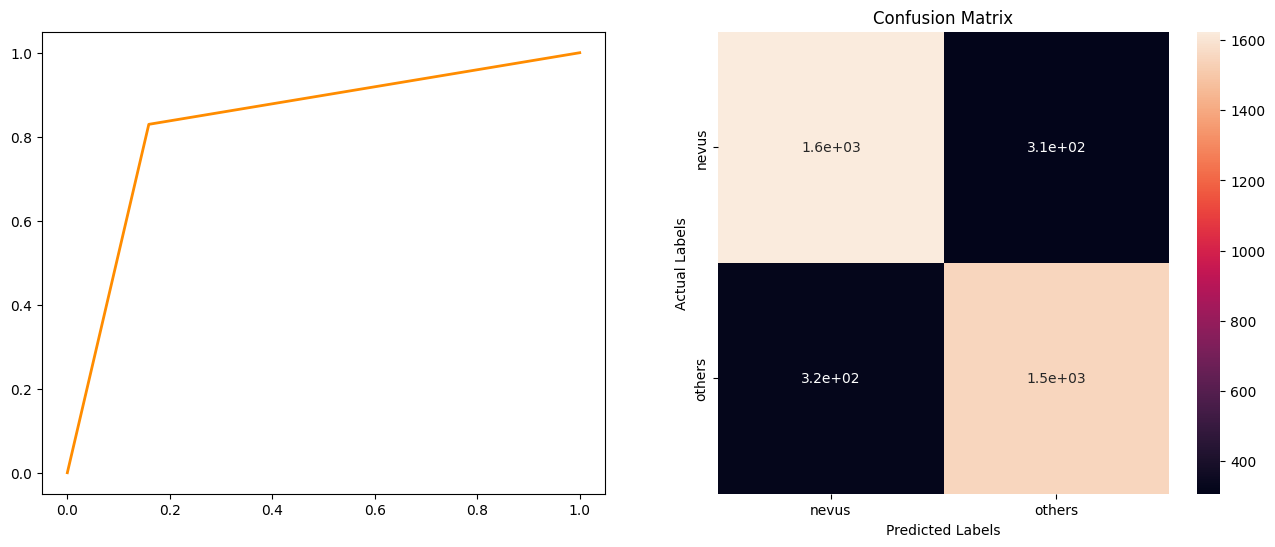

(   [   {   'accuracy': 0.8353530031612223,
            'best_params': {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
            'f1': 0.8319440709868243,
            'kappa': 0.670573226191296,
            'model': SVC(C=10, gamma=0.01),
            'precision': 0.8344120819848975,
            'sensitivity': 0.8294906166219839,
            'specificity': 0.8410150181253236}],)


In [24]:
# Define the list of models and their respective hyperparameter grids
models = [
    SVC()
    ] 

param_grids = [
    {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.001, 0.01, 0.1]},
]

# Call the function to compare models and get the best one
models_report = compare_models(
    models, 
    param_grids, 
    X_train_normalized, 
    y_train_encoded, 
    X_val_normalized, 
    y_val_encoded, 
    scoring_metric='accuracy', 
    cv=5)

pprint_objects(models_report)

(array([[1536,  395],
       [ 333, 1532]], dtype=int64),)


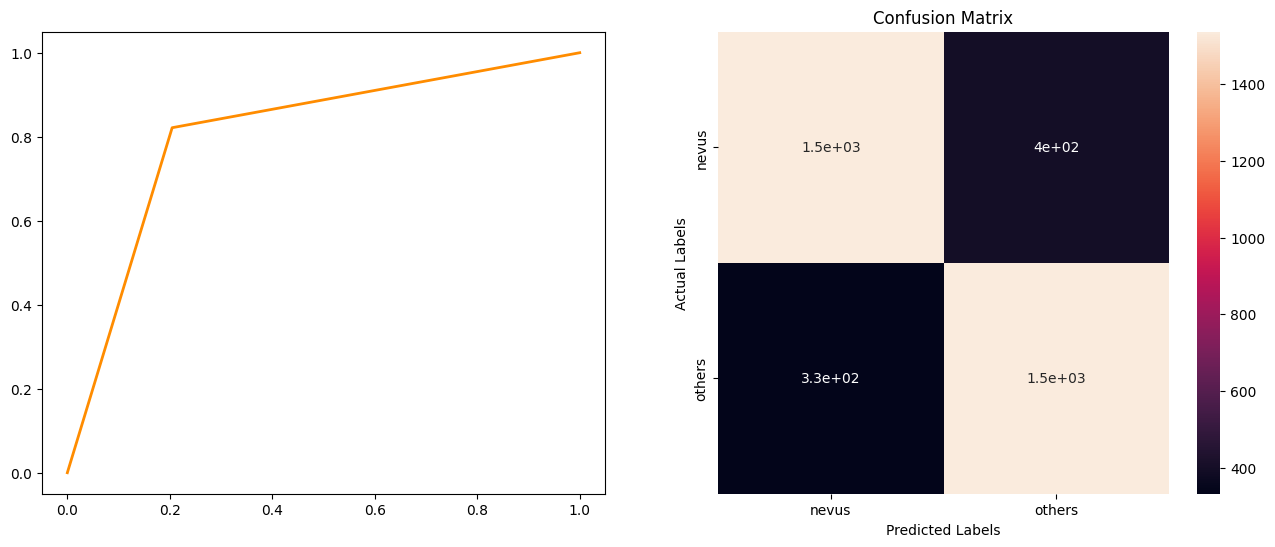

(   [   {   'accuracy': 0.8082191780821918,
            'best_params': {   'algorithm': 'ball_tree',
                               'n_neighbors': 5,
                               'p': 1,
                               'weights': 'distance'},
            'f1': 0.8080168776371308,
            'kappa': 0.6165402245292659,
            'model': KNeighborsClassifier(algorithm='ball_tree', p=1, weights='distance'),
            'precision': 0.7950181629475869,
            'sensitivity': 0.8214477211796246,
            'specificity': 0.7954427757638529}],)


In [27]:
# Define the list of models and their respective hyperparameter grids
models = [
    KNeighborsClassifier()
    ] 
        
param_grids = [
    {'n_neighbors': [3, 5, 7, 9], 'weights' : ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': [1, 2]}, 
]

# Call the function to compare models and get the best one
models_report = compare_models(
    models, 
    param_grids, 
    X_train_normalized, 
    y_train_encoded, 
    X_val_normalized, 
    y_val_encoded, 
    scoring_metric='accuracy', 
    cv=5)

pprint_objects(models_report)

(array([[1608,  323],
       [ 353, 1512]], dtype=int64),)


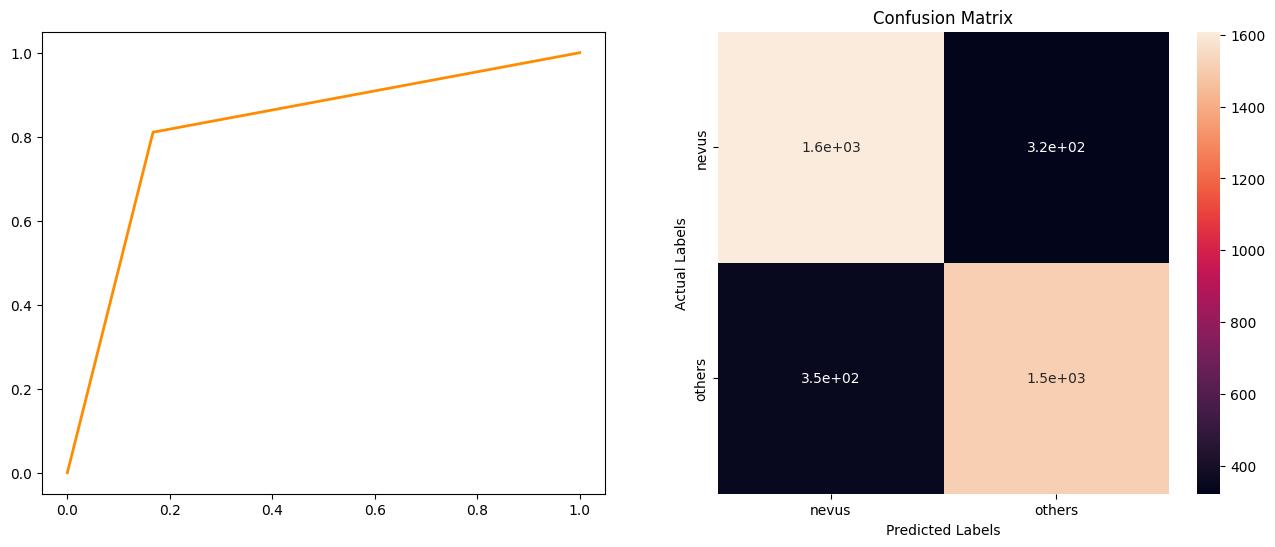

(   [   {   'accuracy': 0.821917808219178,
            'best_params': {   'colsample_bytree': 0.9,
                               'learning_rate': 0.1,
                               'max_depth': 5,
                               'n_estimators': 300,
                               'subsample': 0.7},
            'f1': 0.8172972972972973,
            'kappa': 0.6436299500739517,
            'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, mo

In [25]:
# Define the list of models and their respective hyperparameter grids
models = [
    XGBClassifier()
    ] 

param_grids = [
    {'max_depth': [4, 5], 'learning_rate': [0.1, 0.01], 'n_estimators': [200, 300], 'subsample': [0.5, 0.7, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0]}
]

# Call the function to compare models and get the best one
models_report = compare_models(
    models, 
    param_grids, 
    X_train_normalized, 
    y_train_encoded, 
    X_val_normalized, 
    y_val_encoded, 
    scoring_metric='accuracy', 
    cv=5)

pprint_objects(models_report)

##### 5.4 Training an ensemble (VotingClassifier) using the best models with their best parameters obtained from the previous runs, using only training and validation datasets with (Feature Selection: RFE)

(array([[1624,  307],
       [ 287, 1578]], dtype=int64),)


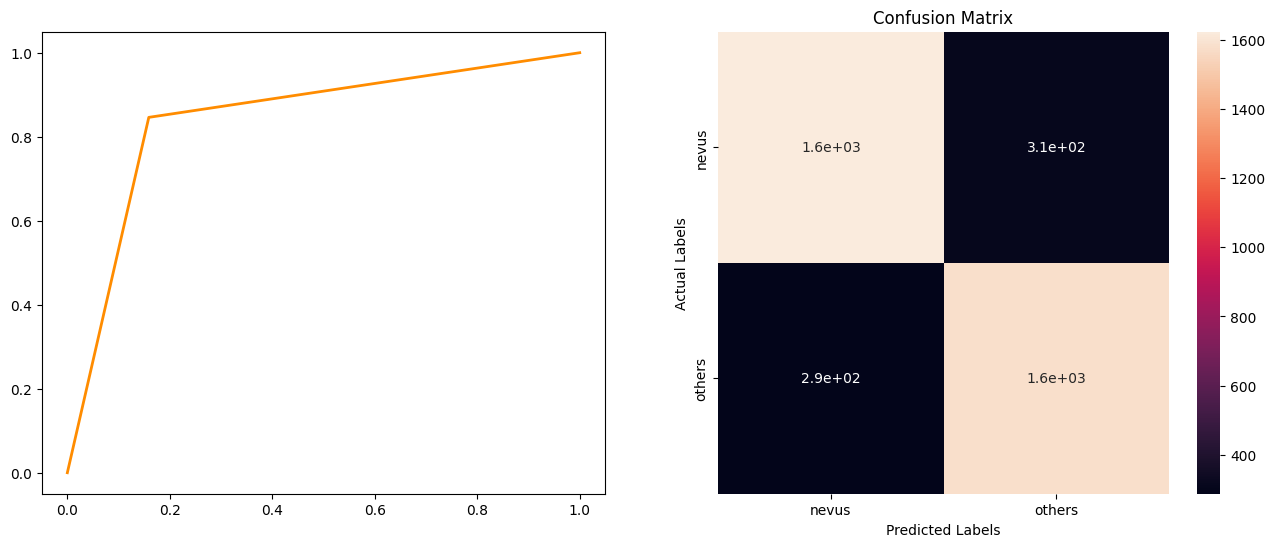

(   [   {   'accuracy': 0.8435194942044257,
            'f1': 0.8416,
            'kappa': 0.6870017143372733,
            'precision': 0.8371352785145889,
            'sensitivity': 0.8461126005361931,
            'specificity': 0.8410150181253236}],)


"\n# clf1 & clf2\n(array([[1636,  295],\n       [ 311, 1554]], dtype=int64),)\n\n(   [   {   'accuracy': 0.8403582718651211,\n            'f1': 0.8368336025848142,\n            'kappa': 0.6805731635889598,\n            'precision': 0.8404542996214169,\n            'sensitivity': 0.8332439678284183,\n            'specificity': 0.8472294148109788}],)\n\n# clf1 & clf2 & clf3\n\n"

In [28]:
# Define the base classifiers
clf1 = SVC(C= 10, gamma=0.01, kernel='rbf', probability=True)  # Set probability=True for soft voting
clf2 = XGBClassifier(colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7)
clf3 = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=5, p=1, weights='distance')

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(estimators=[('svc', clf1), ('xgb', clf2), ('knn', clf3)], voting='soft')

# Train the VotingClassifier on your training data
voting_clf.fit(X_train_normalized, y_train_encoded)

# Make predictions
y_pred = voting_clf.predict(X_val_normalized)

models_report = predict_models(y_pred, y_val_encoded)

pprint_objects(models_report)

'''
# using: clf1 & clf2

(array([[1636,  295],
       [ 311, 1554]], dtype=int64),)

(   [   {   'accuracy': 0.8403582718651211,
            'f1': 0.8368336025848142,
            'kappa': 0.6805731635889598,
            'precision': 0.8404542996214169,
            'sensitivity': 0.8332439678284183,
            'specificity': 0.8472294148109788}],)

-----------------------------------------

# using: clf1 & clf2 & clf3

(array([[1624,  307],
       [ 287, 1578]], dtype=int64),)

(   [   {   'accuracy': 0.8435194942044257,
            'f1': 0.8416,
            'kappa': 0.6870017143372733,
            'precision': 0.8371352785145889,
            'sensitivity': 0.8461126005361931,
            'specificity': 0.8410150181253236}],)

'''


### 6. Test Prediction

For the test dataset, we will repeat the same process of pre-processing, feature extraction, and only train with the best models (ensemble). The training data will contain both training and validation images togather. The final model of testing will be also saved for future use, and the classification results will be exported to an excel file.

##### 6.1 Preprocessing and Feature Extraction on Test Data

In [29]:
ROOT_PATH = Path(Path(os.getcwd())/"../challenge1")

TEST_PATH = ROOT_PATH/"test"

test_X    = sorted(glob(str(TEST_PATH/'testX/*')))
# pprint_objects(test_X)

In [74]:
# Pre-processing and feature extraction
features_dir = r'../output/features/'

experiment              = 4
subsample               = False

test_filename    = f'{experiment}_nevus_others_test_features.csv'

filenames_list = [test_filename]
dir_list = [test_X]

for index, filename in enumerate(filenames_list):
    with open(os.path.join(features_dir, filename), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        for count, image_path in tqdm(enumerate(dir_list[index])):

            if subsample:
                if count == 999: # only 1k per class
                    break

            # reading the image 
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)

            # 1. Copping black frame
            image_without_black_frame, _ = preprocessor.crop_frame(image)

            # 2. Resizing
            image_resized = preprocessor.resize_images(image_without_black_frame, preserve_ratio=True)

            # 3. Removing hair
            image_without_hair = preprocessor.extract_hair(image_resized)

            # 4. Displaying result
            # display_img(image_without_hair)
            
            # 5. Extracting features
            feature_vector = feature_extractor.fit(image_without_hair)

            writer.writerow(feature_vector)

0it [00:00, ?it/s]c:\Users\abdal\Documents\Master\EMJMD MAIA\SEMESTER 3 - UdG\CAD\Melanoma-classification-using-machine-learning\env\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
3375it [33:14,  2.00it/s]C:\Users\abdal\AppData\Local\Temp\ipykernel_32264\2775328039.py:125: RuntimeWarning: divide by zero encountered in scalar divide
  if mean_outside / mean_inside < threshold:
6340it [54:28,  1.94it/s]


Combining both train and validation dataset to train the final model

In [6]:
# Loading the features with the correct experiment number
experiment              = 4

ROOT_PATH = Path(Path(os.getcwd())/"../output/features")

train_nevus_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_train_features.csv',  header = None, on_bad_lines='skip')
val_nevus_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_val_features.csv',  header = None, on_bad_lines='skip')

train_others_df = pd.read_csv(ROOT_PATH/f'{experiment}_others_train_features.csv',  header = None, on_bad_lines='skip')
val_others_df = pd.read_csv(ROOT_PATH/f'{experiment}_others_val_features.csv',  header = None, on_bad_lines='skip')

test_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_others_test_features.csv',  header = None, on_bad_lines='skip')

In [7]:
print(f"Shape of training dataframe for nevus class: {train_nevus_df.shape}")
print(f"Shape of training dataframe for others class: {train_others_df.shape}")
print(f"Shape of validation dataframe for nevus class: {val_nevus_df.shape}")
print(f"Shape of validation dataframe for others class: {val_others_df.shape}")
print(f"Shape of test dataframe: {test_df.shape}")

Shape of training dataframe for nevus class: (7725, 279)
Shape of training dataframe for others class: (7470, 279)
Shape of validation dataframe for nevus class: (1931, 279)
Shape of validation dataframe for others class: (1865, 279)
Shape of test dataframe: (6340, 278)


In [8]:
train_features = pd.concat([train_nevus_df, train_others_df, val_nevus_df, val_others_df], ignore_index=True)
train_features = train_features.sample(frac=1, random_state=42)

print(f"Shape of final training dataframe all classes: {train_features.shape}")

Shape of final training dataframe all classes: (18991, 279)


In [9]:
# Separating the train and validation data to X and y
X_train = train_features.iloc[:,:-1]
y_train = train_features.iloc[:,-1]

X_test  = test_df

# y_train.describe()['count']
X_test.shape

(6340, 278)

In [10]:
# Standardizing the training data (mean = 0, std = 1)
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_test_normalized  = pd.DataFrame(scaler.transform(X_test))

In [11]:
# Encoding the label column
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

In [12]:
print(
    X_train_normalized.shape, 
    y_train_encoded.shape, 
    X_test_normalized.shape)

(18991, 278) (18991,) (6340, 278)


In [13]:
# X_train_normalized, selected_feature_indices  = select_feature.select_bestk_features(X_train_normalized, y_train_encoded)
# X_train_normalized

X_train_normalized, selected_feature_indices  = select_feature.select_rfe_features(X_train_normalized, y_train_encoded)
X_train_normalized

Fitting estimator with 278 features.
Fitting estimator with 277 features.
Fitting estimator with 276 features.
Fitting estimator with 275 features.
Fitting estimator with 274 features.
Fitting estimator with 273 features.
Fitting estimator with 272 features.
Fitting estimator with 271 features.
Fitting estimator with 270 features.
Fitting estimator with 269 features.
Fitting estimator with 268 features.
Fitting estimator with 267 features.
Fitting estimator with 266 features.
Fitting estimator with 265 features.
Fitting estimator with 264 features.
Fitting estimator with 263 features.
Fitting estimator with 262 features.
Fitting estimator with 261 features.
Fitting estimator with 260 features.
Fitting estimator with 259 features.
Fitting estimator with 258 features.
Fitting estimator with 257 features.
Fitting estimator with 256 features.
Fitting estimator with 255 features.
Fitting estimator with 254 features.
Fitting estimator with 253 features.
Fitting estimator with 252 features.
F

,0,1,5,7,8,9,10,11,13,15,...,264,265,266,270,271,272,273,274,275,276
0,0.210068,0.562795,0.885904,0.329345,1.022903,-1.423312,-1.475408,-1.077527,-0.732132,1.140748,...,-0.056165,-0.113332,-0.414246,-0.752705,-1.097404,-0.858782,-0.435654,0.557434,0.361655,-0.725314
1,-1.093421,0.161496,2.095862,-0.835977,-0.207498,-1.813336,-1.859081,-1.234964,-0.804024,-0.330002,...,1.315816,1.312835,1.182484,1.208687,0.212650,-0.496211,-1.151315,-1.143925,-1.078632,-1.155939
2,0.306602,0.409920,0.728774,0.657011,0.526773,-0.512415,-0.610394,-0.543385,-0.457552,1.013647,...,-1.079074,-1.065681,-1.067941,0.168440,0.024395,1.097798,0.591415,0.698262,1.001565,0.519855
3,-1.465658,-0.450007,0.503541,-0.908758,0.248941,-1.111562,-1.308658,-0.920956,-0.704867,-0.802095,...,0.693478,1.563405,1.351851,-0.492453,0.959007,-0.309671,-0.196191,-1.058813,-0.955926,0.378628
4,-0.997602,-1.290824,2.402498,-1.563833,-1.576815,-1.787785,-1.403458,-1.225958,-0.702591,-1.274187,...,1.099464,1.056933,0.784273,-0.031585,-0.425306,-1.279641,-1.732630,-0.989597,-0.570922,-1.311361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18986,-0.747819,-0.392679,-0.335614,-0.597824,-0.167808,-0.109698,-0.550335,-0.232927,-0.453232,-0.729465,...,1.207324,1.367671,1.508823,1.721082,0.952279,0.168503,-0.857553,-1.148616,-1.063629,-0.769757
18987,0.584799,1.136080,1.666927,-0.220243,-3.045359,-1.807273,-0.604274,-1.232844,-0.109448,-2.763095,...,0.310258,0.111772,-0.006785,-0.051858,-0.447439,-0.667766,-1.098909,-0.379166,0.059928,-0.624817
18988,-0.849304,-0.545554,-1.329699,0.124727,0.050489,1.550979,1.071838,1.528621,0.611944,0.014989,...,-2.434810,-2.539401,-2.424310,-2.722460,-2.178270,-1.492844,1.392351,2.990090,3.402695,1.672545
18989,-0.298316,-0.182474,-1.082076,-0.090167,0.050489,0.961400,1.148679,0.814528,0.714629,0.123933,...,0.871808,1.107961,1.422891,0.710399,0.683352,-0.484048,-0.709953,-0.890360,-0.828364,-0.133966


In [14]:
selected_feature_indices

array([  0,   1,   5,   7,   8,   9,  10,  11,  13,  15,  16,  17,  18,
        20,  21,  23,  24,  25,  26,  27,  28,  31,  32,  34,  35,  36,
        42,  43,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  69,  71,  72,  74,  75,  77,
        78,  80,  82,  83,  84,  85,  87,  89,  90,  91,  93,  94,  95,
        96,  97,  98, 100, 101, 102, 103, 104, 106, 107, 109, 110, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       145, 147, 148, 149, 150, 151, 153, 155, 156, 157, 158, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 180, 182, 183, 189, 190, 191, 192, 193, 194, 195, 196,
       198, 199, 200, 201, 202, 204, 210, 211, 213, 214, 216, 217, 218,
       219, 220, 221, 226, 227, 228, 229, 234, 235, 236, 240, 244, 245,
       246, 247, 248, 249, 250, 251, 253, 255, 256, 257, 258, 25

In [15]:
X_test_normalized = X_test_normalized.iloc[:, selected_feature_indices]
X_test_normalized

,0,1,5,7,8,9,10,11,13,15,...,264,265,266,270,271,272,273,274,275,276
0,-2.072753,-0.621992,0.480013,-1.188550,0.050489,1.267434,1.721512,1.173005,1.342765,0.087619,...,-1.045400,-1.589194,-1.450705,-1.614805,-1.226995,-0.704646,0.381564,0.926601,0.460153,1.025156
1,1.554158,0.906766,-1.059776,-0.224780,-0.147963,1.843916,1.254470,1.919737,0.768829,0.014989,...,-0.907700,-0.683351,-0.724582,0.660393,0.245724,1.119595,0.746513,0.739124,0.504075,0.494666
2,-1.851221,-3.564852,0.400459,-1.289222,-3.025513,0.748107,1.220219,0.580243,0.781927,-2.744938,...,-0.383064,-1.002277,-0.661913,-2.839535,1.279934,-0.919211,0.228889,-1.094671,-1.092330,3.401218
3,-1.903886,-3.564852,0.787537,-1.584179,-3.025513,0.197441,2.779825,0.034474,3.062743,-2.744938,...,0.305950,-0.292835,-0.499577,-1.061358,-0.665624,-1.209969,-1.055894,-0.613394,-0.609625,1.092365
4,-0.145854,0.581905,1.258224,-0.537053,1.161819,-1.626631,-1.355683,-1.164931,-0.643636,1.104434,...,1.976373,1.999999,2.213115,1.038396,1.185995,-1.483211,-1.625015,-2.110702,-1.772683,-0.933118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6335,-0.237930,0.027730,0.084210,0.635752,0.606154,-0.096143,0.302432,-0.221685,0.078917,0.523396,...,-1.578967,-1.553636,-1.546858,-1.465800,-0.863688,0.373434,1.812887,1.763442,1.132678,1.360234
6336,0.953966,0.753890,0.107270,0.936863,0.526773,0.107639,-0.069087,-0.046451,-0.194161,0.596026,...,1.800295,1.889899,1.967945,1.678509,0.952279,-0.490081,-1.259687,-1.647718,-1.397608,-0.856827
6337,-0.798739,0.027730,1.017592,-0.646244,0.090180,-0.766887,-0.665666,-0.716069,-0.490814,-0.366317,...,1.278466,0.744339,1.016817,-1.681705,0.107393,-1.329074,-1.072252,-1.499489,-1.411306,-0.364079
6338,1.119105,0.715671,-0.022292,-1.029308,-0.425795,0.135413,0.296971,-0.021665,0.016162,-0.493419,...,-0.477051,-0.378706,-0.515903,0.738781,0.259808,1.191214,0.580510,0.606531,0.432176,-0.073687


Training using the best ensemble model that was experimented before.

In [16]:
# Define the base classifiers
clf1 = SVC(C= 10, gamma=0.01, kernel='rbf', probability=True)  # Set probability=True for soft voting
clf2 = XGBClassifier(colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7)
clf3 = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=5, p=1, weights='distance')

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(estimators=[('svc', clf1), ('xgb', clf2), ('knn', clf3)], voting='soft')

# Train the VotingClassifier on your training data
voting_clf.fit(X_train_normalized, y_train_encoded)

# Make predictions
y_pred = voting_clf.predict(X_test_normalized)

# models_report = predict_models(y_pred, y_val_encoded)

# pprint_objects(models_report)

Saving the model

In [17]:
voting_clf.__dict__

{'estimators': [('svc', SVC(C=10, gamma=0.01, probability=True)),
  ('xgb',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.9, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.1, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=5, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=300, n_jobs=None,
                 num_parallel_tree=None, random_state=None, ...)),
  ('knn',
   KNeighborsClassifier(algorithm='ball_tree', p=1, weights='distance'))],
 'voting': 'soft',
 'weights': None,
 'n_jobs': None

In [18]:
# Save the VotingClassifier model to a file
joblib.dump(voting_clf, '../output/HabibAlvarez_ch1_voting_classifier_rfe_model.pkl')

['../output/HabibAlvarez_ch1_voting_classifier_rfe_model.pkl']

In [19]:
# save the predictions as excel file with one column with the classification result
y_pred

array([1, 0, 1, ..., 1, 0, 1], dtype=int64)

In [129]:
# Create a DataFrame with the predictions
df_test = pd.DataFrame({'Predictions': y_pred})

# Save the DataFrame to an Excel file
df_test.to_excel('../output/HabibAlvarez_ch1_voting_classifier_rfe_model_predictions.xlsx', header=False, index=False)